In [1]:
from skimage import io
from skimage.feature import canny
from PIL import Image
import cv2 as cv
from skimage.transform import rescale
from skimage.morphology import dilation, disk
import matplotlib.pyplot as plt
import numpy as np
from skimage.transform import ProjectiveTransform, warp
from PIL import Image  
import PIL
import os
import sys
import pandas as pd

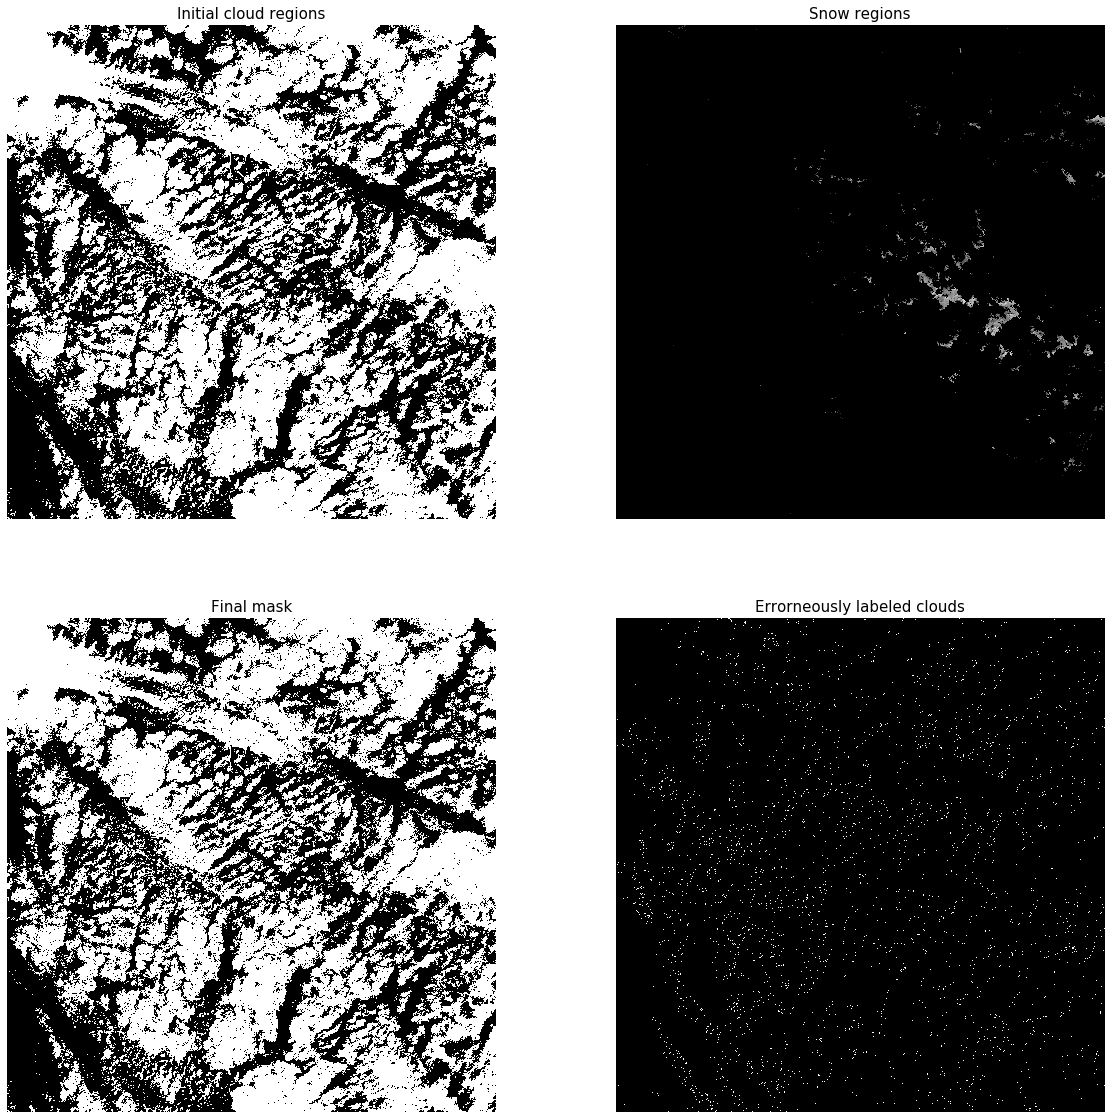

In [2]:
mask_train = './data/LC08_L1TP_047023_20160920_20170221_01_T1_BQA.TIF'
B2 = './data/LC08_L1TP_047023_20160920_20170221_01_T1_B2.TIF'

fig1, axes = plt.subplots(2, 2, figsize=[20, 20])
axes[0, 0].set_title('Initial cloud regions', fontsize=15)
axes[0, 1].set_title('Snow regions', fontsize=15)
axes[1, 1].set_title('Errorneously labeled clouds', fontsize=15)
axes[1, 0].set_title('Final mask', fontsize=15)
axes[0, 0].axis('off')
axes[1, 0].axis('off')
axes[1, 1].axis('off')
axes[0, 1].axis('off')

image = io.imread(mask_train)
points_desired = np.array([[image.shape[1],0], [0,0], [0,image.shape[0]], [image.shape[1],image.shape[0]]])
points_current = np.array([[7420,1520], [1800, 120], [120, 6200], [6100, 7600]])
tform = ProjectiveTransform()
tform.estimate(points_desired, points_current)
    
cloud = image
cloud[cloud==1]=0
cloud[cloud==2800]=1
cloud[cloud==2804]=1
cloud[cloud==2808]=1
cloud[cloud==2812]=1
cloud[cloud==6896]=1
cloud[cloud==6900]=1
cloud[cloud==6904]=1
cloud[cloud==6908]=1
cloud[cloud!=1]=0
cloud= warp(cloud, tform)
cloud = cloud/np.max(cloud)
cloud[cloud<0.5]=0
cloud[cloud!=0]=1
cloud_raw = cloud
axes[0, 0].imshow(cloud_raw, cmap='gray')
    
image = io.imread(mask_train)
    
snow = image
snow[snow==1]=0
snow[snow==3744]=1
snow[snow==3748]=1
snow[snow==3752]=1
snow[snow==3756]=1
snow[snow==3776]=1
snow[snow==3780]=1
snow[snow==3784]=1
snow[snow==3788]=1
snow[snow==7840]=1
snow[snow==7844]=1
snow[snow==7848]=1
snow[snow==7852]=1
snow[snow==7872]=1
snow[snow==7876]=1
snow[snow==7880]=1
snow[snow==7884]=1
snow[snow!=1]=0
snow = snow/np.max(snow)
snow= warp(snow, tform)
snow[snow<0.5]=0
snow[snow!=0]=1

B2=io.imread(B2)
B2= warp(B2, tform)
snow_B2=B2*snow
axes[0, 1].imshow(snow_B2, cmap='gray')
    
grad_x_snow, grad_y_snow = np.gradient(snow_B2)
av_x = np.sum(abs(grad_x_snow))/np.sum(snow)
av_y = np.sum(abs(grad_y_snow))/np.sum(snow)

grad_x_B2, grad_y_B2 = np.gradient(B2)
grad_x_B2[abs(grad_x_B2)>av_x*0.8]=0
grad_x_B2[(abs(grad_x_B2)<av_x*0.8)&(grad_x_B2!=0)]=1
grad_y_B2[abs(grad_y_B2)>av_y*0.8]=0
grad_y_B2[(abs(grad_y_B2)<av_y*0.8)&(grad_y_B2!=0)]=1
grad_B2 = grad_y_B2*grad_x_B2

cloud_cor = grad_B2*cloud
axes[1, 0].imshow(cloud_cor, cmap='gray')
err = (1-grad_B2)*cloud
axes[1, 1].imshow(err, cmap='gray')
# cloud = Image.fromarray((cloud*255).astype(np.uint8))
# cloud.save('./data/masks/processed/rotated/{}'.format(files_masks[i]))
# im = Image.fromarray((im*255).astype(np.uint8))
# im.save('./data/masks/processed/rotated/corrected/{}'.format(files_masks[i]))

In [3]:
manual_mask  = io.imread('./data/GT.jpg')
manual_mask = warp(manual_mask, tform)
manual_mask=1 - manual_mask/np.max(manual_mask)
manual_mask[manual_mask<0.5]=0
manual_mask[manual_mask!=0]=1
np.unique(manual_mask)

array([0., 1.])

In [9]:
np.unique(np.array(img))

array([255], dtype=uint8)

In [5]:
n=0
image = cloud_cor
for i in range(19):
    for j in range(19):
        if n<300:
            img = image[384*i:384*(i+1), 384*j:384*(j+1)]
            img=rescale(img, scale = 0.5)
            img[img<0.5]=0
            img[img!=0]=1
            img = Image.fromarray((img*255).astype(np.uint8))
            img.save('data/Train/Cor/{}.TIF'.format(n))
        n+=1

n=0
image = cloud_raw
for i in range(19):
    for j in range(19):
        if n<300:
            img = image[384*i:384*(i+1), 384*j:384*(j+1)]
            img=rescale(img, scale = 0.5)
            img[img<0.5]=0
            img[img!=0]=1
            img = Image.fromarray((img*255).astype(np.uint8))
            img.save('./data/Train/Raw/{}.TIF'.format(n))
        n+=1
        
n=0
image = manual_mask
for i in range(19):
    for j in range(19):
        if n>=300:
            img = image[384*i:384*(i+1), 384*j:384*(j+1)]
            img=rescale(img, scale = 0.5)
            img[img<0.5]=0
            img[img!=0]=1
            img = Image.fromarray((img*255).astype(np.uint8))
            img.save('./data/Test/Target/{}.TIF'.format(n))
        n+=1

In [6]:
layers=['B2', 'B3', 'B4', 'B5']
img_warped = []
for B in layers: 
    file = './data/LC08_L1TP_047023_20160920_20170221_01_T1_{}.TIF'.format(B)
    img_full=io.imread(file, plugin='matplotlib')
    tform.estimate(points_desired, points_current)
    image_warped = warp(img_full, tform)
    img_warped.append(image_warped)

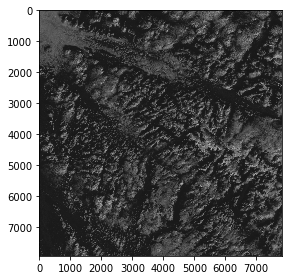

In [8]:
io.imshow(img_warped[1])

In [9]:
for k in range(len(layers)):
    n=0
    image = img_warped[k]
    for i in range(19):
        for j in range(19):
            if n<300:
                img = image[384*i:384*(i+1), 384*j:384*(j+1)]
                img=rescale(img, scale = 0.5)
                img = Image.fromarray((img*255).astype(np.uint8))
                img.save('./data/Train/{}/{}.TIF'.format(layers[k], n))
            if n>=300:
                img = image[384*i:384*(i+1), 384*j:384*(j+1)]
                img=rescale(img, scale = 0.5)
                img = Image.fromarray((img*255).astype(np.uint8))
                img.save('./data/Test/{}/{}.TIF'.format(layers[k], n))
            n+=1 